<a href="https://colab.research.google.com/github/aarushitahil/spam-detection/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/spam.csv', encoding='latin-1')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data = df[['v1', 'v2']]
data.columns = ['label', 'message']

data['label'] = data['label'].map({'ham': 0, 'spam': 1}) # Map labels to binary values

<ipython-input-4-98ebef1ca87d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map({'ham': 0, 'spam': 1}) # Map labels to binary values


In [6]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

nltk.download('punkt_tab')

data['tokens'] = data['message'].apply(word_tokenize) #tokenising

word2vec_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=1, workers=4) #training model


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-6-f28068201fd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokens'] = data['message'].apply(word_tokenize) #tokenising


In [7]:
import numpy as np

def get_average_word2vec(tokens_list, model, vector_size=100):
    # compute average Word2Vec vector for a message
    valid_embeddings = [model.wv[word] for word in tokens_list if word in model.wv]
    if not valid_embeddings:
        return np.zeros(vector_size)
    return np.mean(valid_embeddings, axis=0)

data['vector'] = data['tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model)) #apply to all messages


<ipython-input-7-f2235c686c22>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vector'] = data['tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model)) #apply to all messages


In [8]:
from sklearn.model_selection import train_test_split

X = np.stack(data['vector'].values)
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# define parameter grid for tuning
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']} # c is regularization parameter

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")

best_model = grid.best_estimator_ # train best model


Best parameters found: {'C': 10, 'solver': 'lbfgs'}


In [10]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Accuracy: 0.91
              precision    recall  f1-score   support

         Ham       0.92      0.99      0.95       965
        Spam       0.85      0.42      0.56       150

    accuracy                           0.91      1115
   macro avg       0.88      0.70      0.76      1115
weighted avg       0.91      0.91      0.90      1115



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 137 (\x89) missing from current font.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


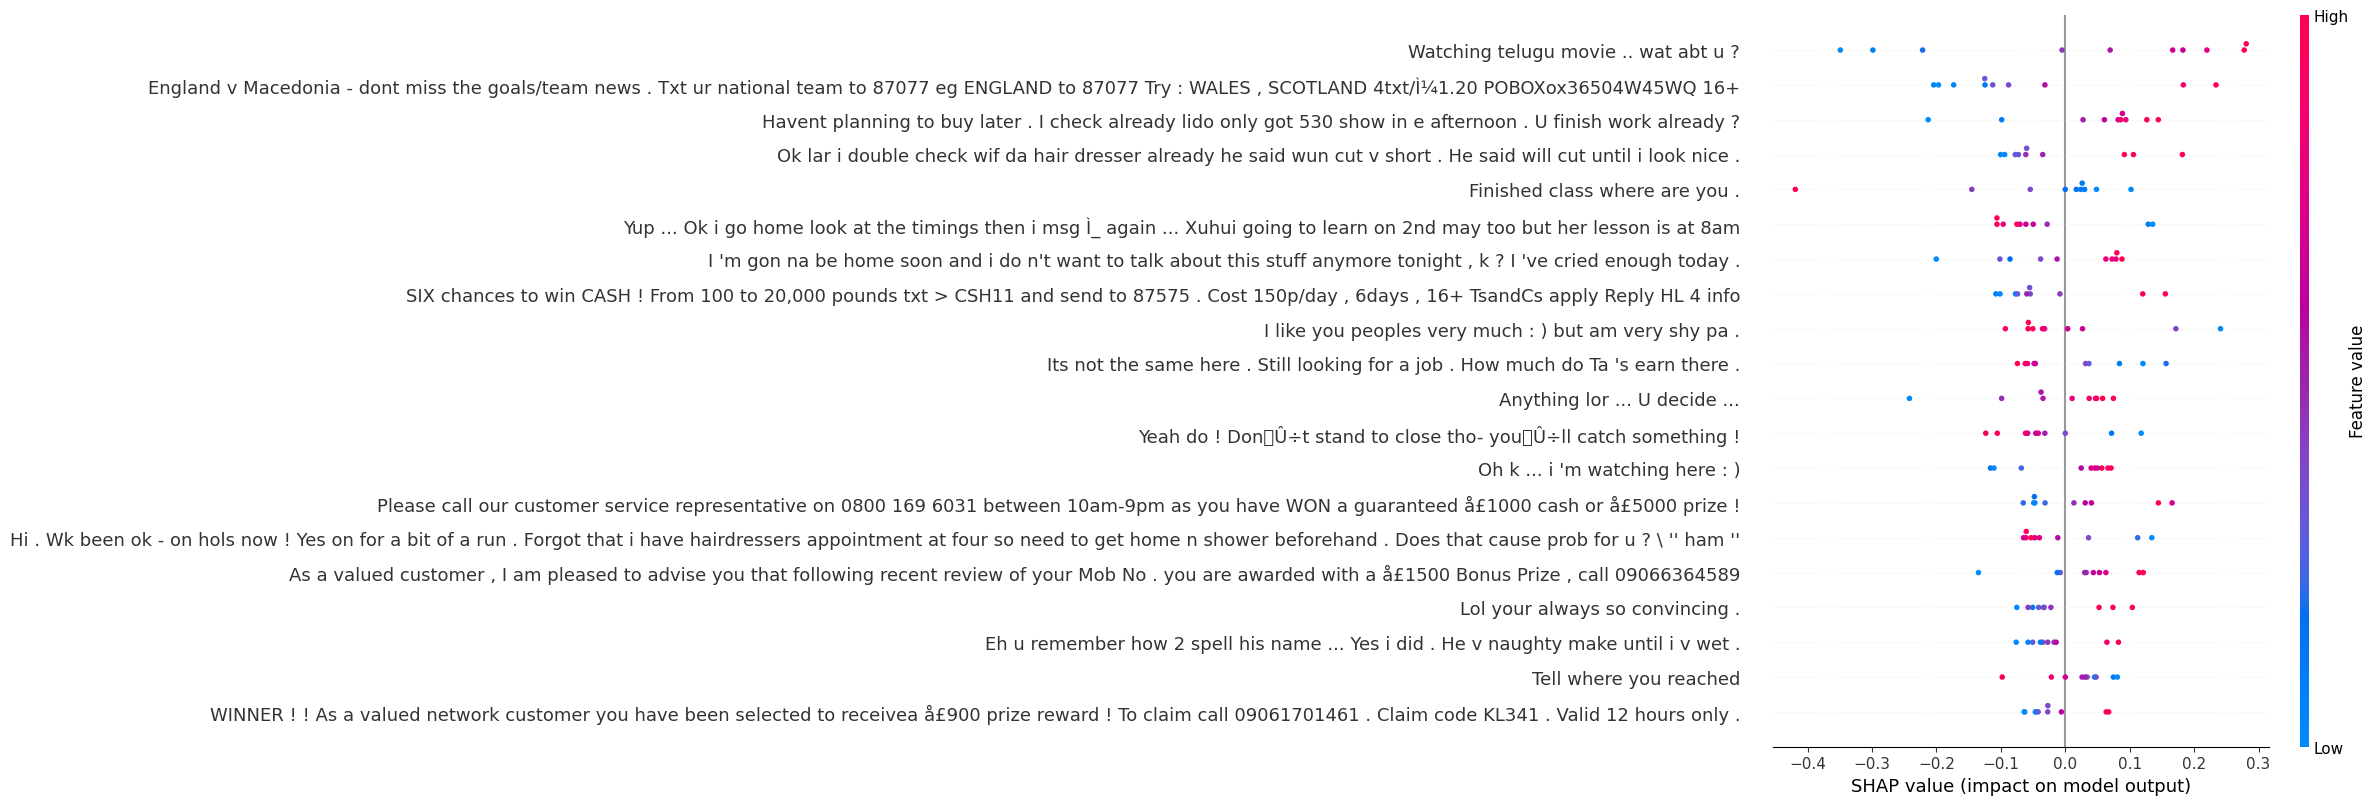

<Figure size 640x480 with 0 Axes>

In [15]:
import shap
import matplotlib.pyplot as plt

explainer = shap.KernelExplainer(best_model.predict, X_train[:100])  # use a subset to speed up SHAP
shap_values = explainer.shap_values(X_test[:10])  # sample some test data
feature_names = data['tokens'].apply(' '.join).tolist()

plt.figure(figsize=(12, 12))
shap.summary_plot(shap_values, X_test[:10], feature_names=feature_names)
plt.tight_layout()
plt.show()


###Testing

In [19]:
new_messages = ["Congratulations! You've won a $1000 Walmart gift card. Click here to claim.", "Hey, are we still meeting for lunch tomorrow?"]

new_messages_tokens = [word_tokenize(msg) for msg in new_messages]
new_messages_vectors = np.array([get_average_word2vec(tokens, word2vec_model) for tokens in new_messages_tokens])

predictions = best_model.predict(new_messages_vectors)

for msg, label in zip(new_messages, predictions):
    print(f"'{msg}' - {'Spam' if label else 'Ham'}")

'Congratulations! You've won a $1000 Walmart gift card. Click here to claim.' - Spam
'Hey, are we still meeting for lunch tomorrow?' - Ham
